In [1]:
import pandas as pd # pake untuk baca datasetsnya, karna datasetnya banyak yang 0
import numpy as np 
import matplotlib.pyplot as plt # plotting
from sklearn.model_selection import train_test_split, cross_val_score
# algorithm machine learning untuk klasifikasi, pake teknik ensemble 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
# banyakin datasetsnya
from sklearn.utils import resample
# simpan model baru
import joblib

In [2]:
df = pd.read_csv('train.csv', header=None)

df.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
              'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

print("Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")
print(f"Diabetes cases: {df['Outcome'].sum()} out of {len(df)} ({df['Outcome'].mean()*100:.1f}%)")

print("\nFirst 5 rows:")
print(df.head())

Dataset loaded successfully!
Dataset shape: (768, 9)
Diabetes cases: 268 out of 768 (34.9%)

First 5 rows:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  



Dataset statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000

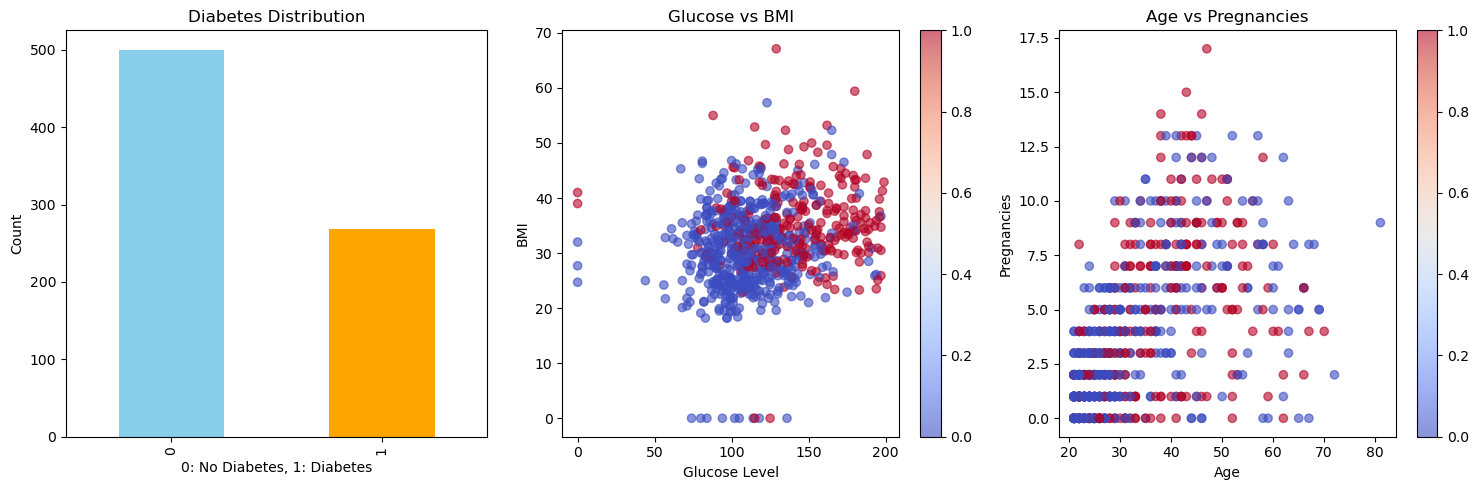

In [3]:
print("\nDataset statistics:")
print(df.describe())

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df['Outcome'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Diabetes Distribution')
plt.xlabel('0: No Diabetes, 1: Diabetes')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.scatter(df['Glucose'], df['BMI'], c=df['Outcome'], alpha=0.6, cmap='coolwarm')
plt.xlabel('Glucose Level')
plt.ylabel('BMI')
plt.title('Glucose vs BMI')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.scatter(df['Age'], df['Pregnancies'], c=df['Outcome'], alpha=0.6, cmap='coolwarm')
plt.xlabel('Age')
plt.ylabel('Pregnancies')
plt.title('Age vs Pregnancies')
plt.colorbar()

plt.tight_layout()
plt.show()


# Gambar 1 
-> jumlah data orang yang kena diabetes atau tidak, di gambarnya berarti adalah 
yang ga kena diabetes adalah +- 500 orang dan yang kena diabetes adalah +- 300 orang 

# Gambar 2 
-> Hubungan antara 2 feature Glucose dan BMI dengan variable target (outcome), 
dari gambarnya berarti jelas pasien dengan tingkat glukosa yagn lebih tinggi dan BMI
yang lebih tinggi mungkin menderita diabetes (titik2 merah itu diabetes) cenderung ke area 
kanan atas plot

yang titik titik biru (tidak diabetes) itu cenderung ke area kiri bawah yang kalau diliat
BMi dan Glukosanya rendah

# Gambar 3 
-> Visualisasi hubungan antara Age dan Pregnancies dengan variable outcome
hasilnya ga sejelas antara Glucose vs BMI, tapi ada sedikit pola
titik2 merah(diabetes) banyak kumpul di area pasien yang lebih tua (age lebih tinggi)
dan dengan jumlah kehamilan yang lebih banyak (pregnancies)
ini cuman kasi tau aja kalau umur yang tinggi dan pregnancies banyak terkena diabetes

In [4]:
print("Preprocessing data...")

# Jadi didatasetnya banyak yang ilang jadinya disini mau diresample lagi 
# bagian feature yang sering 0 valuenya
medical_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for col in medical_columns:
    median_val = df[df[col] != 0][col].median()
    df[col] = df[col].replace(0, median_val)
    print(f"Replaced zeros in {col} with median: {median_val:.1f}")

df_majority = df[df.Outcome == 0]  # No diabetes
df_minority = df[df.Outcome == 1]  # Diabetes

print(f"\nOriginal distribution: {len(df_majority)} no diabetes, {len(df_minority)} diabetes")

# Mau balance kan dataset dengan cara upsampling 
df_minority_upsampled = resample(df_minority, 
                                replace=True,
                                n_samples=len(df_majority),
                                random_state=42)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced distribution: {len(df[df.Outcome == 0])} no diabetes, {len(df[df.Outcome == 1])} diabetes")

Preprocessing data...
Replaced zeros in Glucose with median: 117.0
Replaced zeros in BloodPressure with median: 72.0
Replaced zeros in SkinThickness with median: 29.0
Replaced zeros in Insulin with median: 125.0
Replaced zeros in BMI with median: 32.3

Original distribution: 500 no diabetes, 268 diabetes
Balanced distribution: 500 no diabetes, 500 diabetes


In [5]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Split data test sama train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print("Training Gradient Boosting model...")

# pake model gradient boosting nya
model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

cv_scores = cross_val_score(model, X_train, y_train, cv=5)

print(f"\nModel Performance:")
print(f"Test Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"Cross-validation: {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


Training set: 800 samples
Test set: 200 samples
Training Gradient Boosting model...

Model Performance:
Test Accuracy: 0.880 (88.0%)
Cross-validation: 0.851 (+/- 0.035)

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       100
           1       0.84      0.94      0.89       100

    accuracy                           0.88       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.88      0.88       200



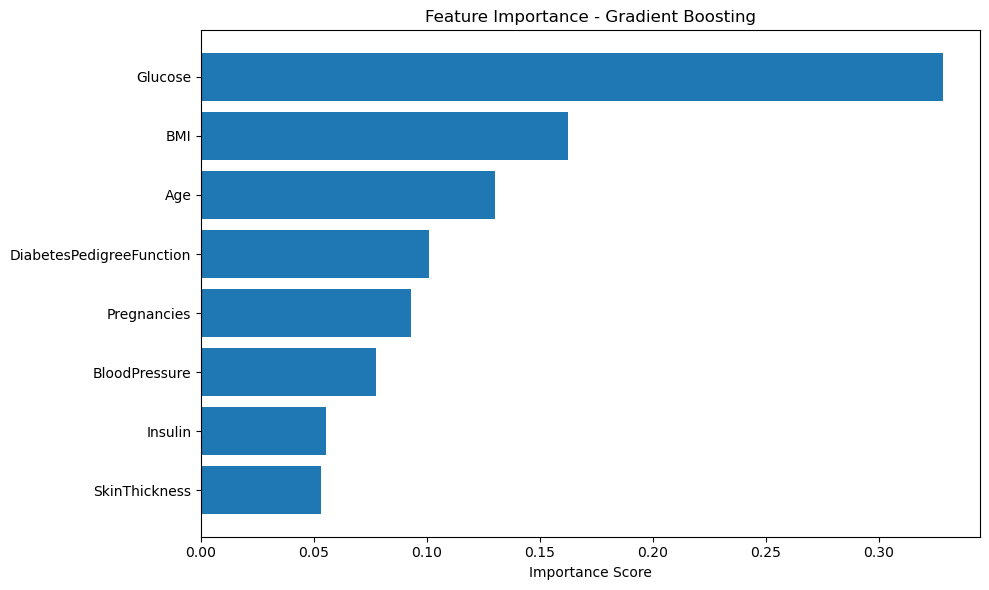

Feature Importance Ranking:
                    Feature  Importance
1                   Glucose    0.328479
5                       BMI    0.162322
7                       Age    0.130009
6  DiabetesPedigreeFunction    0.100824
0               Pregnancies    0.092929
2             BloodPressure    0.077236
4                   Insulin    0.055123
3             SkinThickness    0.053079


In [6]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title('Feature Importance - Gradient Boosting')
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("Feature Importance Ranking:")
print(importance_df)

In [7]:

def predict_diabetes(pregnancies, glucose, blood_pressure, skin_thickness, 
                    insulin, bmi, diabetes_pedigree, age):
    """
    Predict diabetes risk for an individual
    
    Parameters:
    - pregnancies: Number of pregnancies
    - glucose: Glucose level (mg/dL)
    - blood_pressure: Blood pressure (mmHg)
    - skin_thickness: Tricep skin fold thickness (mm)
    - insulin: 2-Hour serum insulin (mu U/ml)
    - bmi: Body mass index
    - diabetes_pedigree: Diabetes pedigree function
    - age: Age (years)
    
    Returns:
    - prediction: 0 (No Diabetes) or 1 (Diabetes)
    - probability: Risk probability (0-1)
    """
    
    input_values = [pregnancies, glucose, blood_pressure, skin_thickness, 
                   insulin, bmi, diabetes_pedigree, age]
    
    medians = [3.0, 117.0, 72.0, 23.0, 79.5, 32.0, 0.5, 29.0]
    for i, (val, median) in enumerate(zip(input_values, medians)):
        if val == 0 and i in [1, 2, 3, 4, 5]:  
            input_values[i] = median
    
    input_data = [input_values]
    
    prediction = model.predict(input_data)[0]
    probability = model.predict_proba(input_data)[0][1]
    
    return prediction, probability

print("Sample Predictions:")
print("=" * 50)

# Test case 1
pred, prob = predict_diabetes(6, 148, 72, 35, 0, 33.6, 0.627, 50)
risk = "High" if prob > 0.7 else "Medium" if prob > 0.3 else "Low"
print(f"Case 1: {'Diabetes' if pred == 1 else 'No Diabetes'} | Risk: {prob:.1%} ({risk})")

# Test case 2
pred, prob = predict_diabetes(1, 85, 66, 29, 0, 26.6, 0.351, 31)
risk = "High" if prob > 0.7 else "Medium" if prob > 0.3 else "Low"
print(f"Case 2: {'Diabetes' if pred == 1 else 'No Diabetes'} | Risk: {prob:.1%} ({risk})")

# Test case 3
pred, prob = predict_diabetes(2, 110, 80, 25, 120, 28.5, 0.4, 35)
risk = "High" if prob > 0.7 else "Medium" if prob > 0.3 else "Low"
print(f"Case 3: {'Diabetes' if pred == 1 else 'No Diabetes'} | Risk: {prob:.1%} ({risk})")

Sample Predictions:
Case 1: Diabetes | Risk: 85.0% (High)
Case 2: No Diabetes | Risk: 0.9% (Low)
Case 3: No Diabetes | Risk: 2.4% (Low)


c:\Users\kowlin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kowlin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kowlin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kowlin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kowlin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\kowlin\anaconda3\Lib\site-

In [8]:
def diabetes_risk_assessment():
    """
    Interactive diabetes risk assessment tool
    """
    print("\n" + "=" * 40)
    print("DIABETES RISK ASSESSMENT")
    print("=" * 40)
    
    try:
        print("Please enter the following information:")
        pregnancies = int(input("Number of pregnancies: "))
        glucose = float(input("Glucose level (mg/dL): "))
        blood_pressure = float(input("Blood pressure (mmHg): "))
        skin_thickness = float(input("Skin thickness (mm): "))
        insulin = float(input("Insulin level (mu U/ml): "))
        bmi = float(input("BMI: "))
        diabetes_pedigree = float(input("Diabetes pedigree function: "))
        age = int(input("Age: "))
        
        prediction, probability = predict_diabetes(
            pregnancies, glucose, blood_pressure, skin_thickness,
            insulin, bmi, diabetes_pedigree, age
        )
        
        print("\n" + "-" * 30)
        print("ASSESSMENT RESULTS")
        print("-" * 30)
        
        if prediction == 1:
            print("⚠️  DIABETES RISK DETECTED")
        else:
            print("✅ LOW DIABETES RISK")
        
        print(f"Risk Probability: {probability:.1%}")
        
        if probability > 0.7:
            print("Recommendation: 🏥 Consult healthcare provider immediately")
        elif probability > 0.3:
            print("Recommendation: 📊 Regular monitoring and lifestyle changes")
        else:
            print("Recommendation: 💪 Maintain healthy lifestyle")
            
    except ValueError:
        print("❌ Please enter valid numeric values")
    except Exception as e:
        print(f"❌ Error: {e}")

In [9]:
model_filename = 'predict_diabetes.pkl'
joblib.dump(model, model_filename)

print(f"\n✅ Model saved as: {model_filename}")

print("\n" + "=" * 60)
print("🎯 DIABETES PREDICTION MODEL - SUMMARY")
print("=" * 60)

print(f"✅ Model: Gradient Boosting Classifier")
print(f"✅ Accuracy: {accuracy:.3f} ({accuracy*100:.1f}%)")
print(f"✅ Cross-validation: {cv_scores.mean():.3f}")
print(f"✅ Dataset: {len(df)} samples, {len(X.columns)} features")
print(f"✅ Test samples: {len(X_test)}")

print(f"\n🔝 Top 3 Most Important Features:")
for i in range(min(3, len(importance_df))):
    feature = importance_df.iloc[i]
    print(f"{i+1}. {feature['Feature']}: {feature['Importance']:.3f}")

print("\n📋 Usage:")
print("   - Use predict_diabetes() for single predictions")
print("   - Use diabetes_risk_assessment() for interactive assessment")
print("   - Model ready for deployment!")


✅ Model saved as: predict_diabetes.pkl

🎯 DIABETES PREDICTION MODEL - SUMMARY
✅ Model: Gradient Boosting Classifier
✅ Accuracy: 0.880 (88.0%)
✅ Cross-validation: 0.851
✅ Dataset: 1000 samples, 8 features
✅ Test samples: 200

🔝 Top 3 Most Important Features:
1. Glucose: 0.328
2. BMI: 0.162
3. Age: 0.130

📋 Usage:
   - Use predict_diabetes() for single predictions
   - Use diabetes_risk_assessment() for interactive assessment
   - Model ready for deployment!
